In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

from tqdm import tqdm_notebook

import config
from audio import audio_to_melspectrogram, show_melspectrogram
from utils import load_labels, show_spectrograms

<IPython.core.display.Javascript object>

## Load data

In [3]:
# read data
X_train = np.load("../data/DOCC10_train/DOCC10_Xtrain.npy")
X_test = np.load("../data/DOCC10_test/DOCC10_Xtest.npy")
Y_train_df = pd.read_csv("../data/DOCC10_train/DOCC10_Ytrain.csv", index_col=0)

# Shift indexes
Y_train_df.index = Y_train_df.index - 20960

all_classes = list(set(Y_train_df.TARGET.values))

print("X train", X_train.shape, "Y_train", Y_train_df.shape, "X_test", X_test.shape)

X train (113120, 8192) Y_train (113120, 1) X_test (20960, 8192)


<IPython.core.display.Javascript object>

## Segment clicks 

In [4]:
def get_center(x_r):
    # Parameters
    cutoff = 10000
    win_size = 50
    gaussian_std = 5
    fs = 200000
    nyq = fs // 2
    order = 2
    normal_cutoff = cutoff / nyq

    # Butterworth highpass filter
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    x_h = signal.filtfilt(b, a, x_r)

    # Wiener filter
    x_w = signal.wiener(x_h, mysize=win_size)

    # Gaussian filter
    x_g = gaussian_filter1d(np.abs(x_w), gaussian_std)

    # Argmax of the resulting signal
    center = x_g.argmax()

    return center

<IPython.core.display.Javascript object>

In [5]:
def show_centers(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j in range(len(classes)):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            center = get_center(X_sub[idx])
            axes[i, j].plot(X_sub[idx])
            axes[i, j].axvline(x=center, color="red")
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

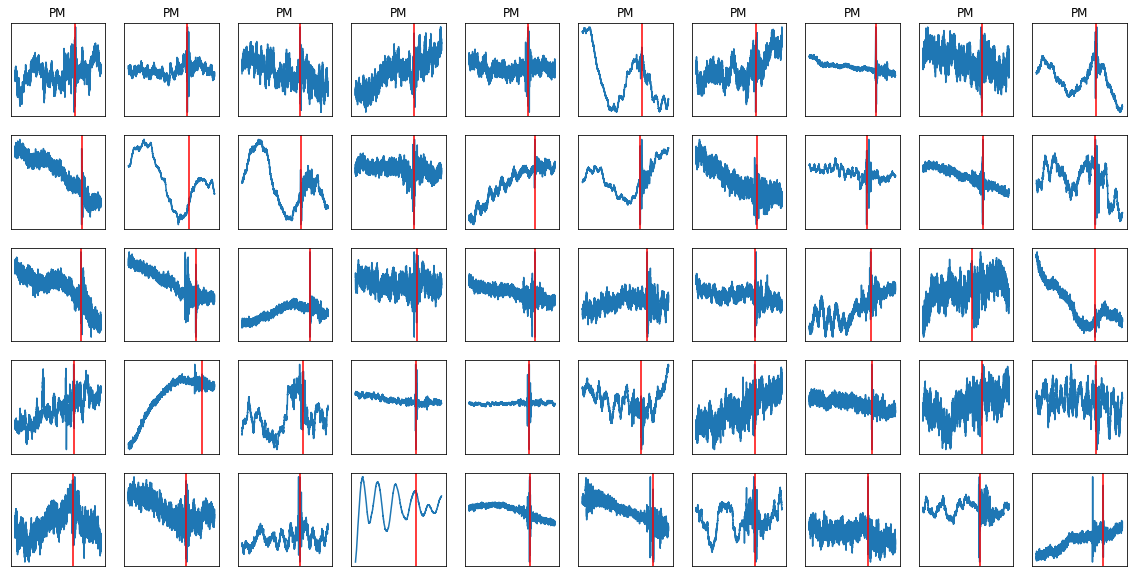

<IPython.core.display.Javascript object>

In [6]:
show_centers(5, ["PM"] * 10)

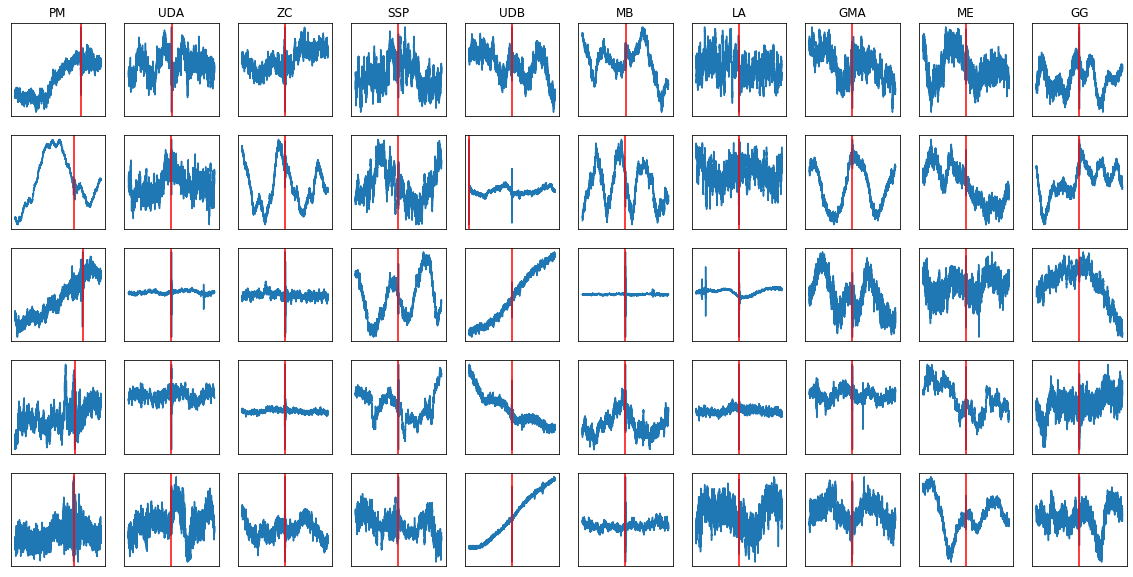

<IPython.core.display.Javascript object>

In [7]:
show_centers(5, all_classes)

In [8]:
def segment_clicks(x, cls=None, width=2 ** 8):
    T = len(x)
    assert width < T
    if cls == "PM":
        center = get_center(x)
    else:
        center = 2 ** 12
    if center - width // 2 < 0:
        min_t = 0
        max_t = width
    elif center + width // 2 >= T:
        min_t = -width
        max_t = T
    else:
        min_t = center - width // 2
        max_t = center + width // 2
    x_sub = x[min_t:max_t]
    assert len(x_sub) == width
    return x_sub

<IPython.core.display.Javascript object>

## Spectral features

### Feature: centered power spectrum bins

In [9]:
def get_power_spectrum(x, n_fft=64):
    n_fft = 64
    cutoff = 10000
    f_sampling = 200000
    window = signal.get_window(("gaussian", 30), n_fft)

    f, pspec = signal.welch(x, f_sampling, window, n_fft, scaling="spectrum")

    # Keep only freq > 10kHz
    pspec = pspec[f > cutoff]
    f = f[f > cutoff]
    return f, pspec

<IPython.core.display.Javascript object>

In [53]:
def show_temporal(x, vert=[]):
    plt.figure(figsize=(10, 5))
    plt.title("Signal")
    plt.plot(x)
    plt.yticks([])
    for v in vert:
        plt.axvline(x=v, color="red")
    plt.show()


def show_power_spectrum(f, ps):
    plt.figure(figsize=(10, 5))
    plt.title("Power spectrum")
    N = len(f)
    ind = np.arange(N)
    delta = f[1] - f[0]
    xlabels = (f - delta / 2).astype(int)
    plt.bar(x=ind, height=ps)
    plt.xticks(ind, xlabels, rotation=45)
    plt.yticks([])
    plt.show()

<IPython.core.display.Javascript object>

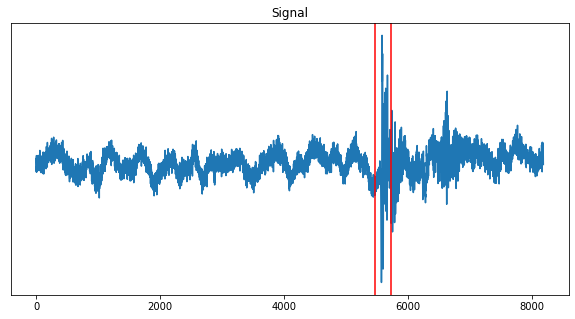

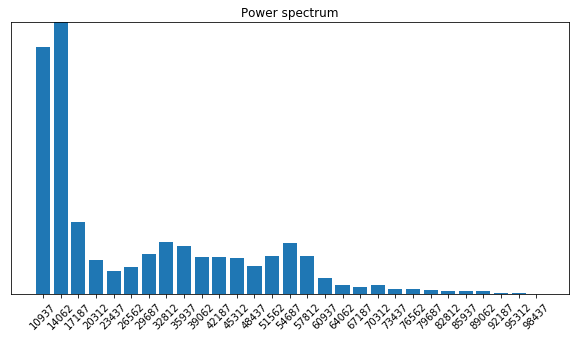

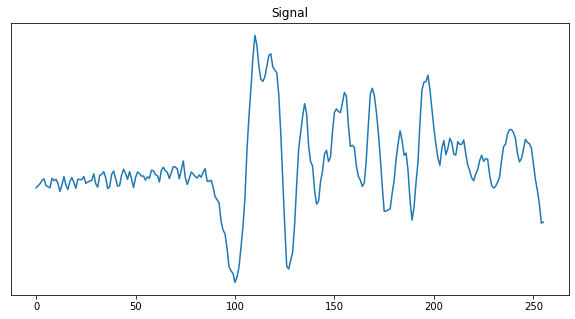

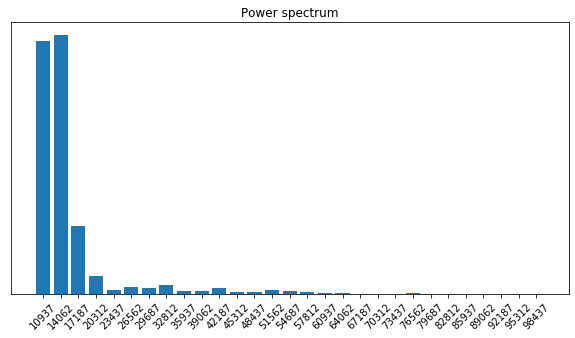

<IPython.core.display.Javascript object>

In [54]:
# Test
x_idx = 90496
x = X_train[x_idx]
x_cls = Y_train_df.loc[x_idx].TARGET
f, ps = get_power_spectrum(x, n_fft=64)
x_c = segment_clicks(x, cls=x_cls, width=2 ** 8)
f_c, ps_c = get_power_spectrum(x_c, n_fft=64)

show_temporal(x, [get_center(x) - 2 ** 7, get_center(x) + 2 ** 7])
show_power_spectrum(f, ps)
show_temporal(x_c)
show_power_spectrum(f_c, ps_c)

In [37]:
def show_power_spectrum_per_class(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j, cls in enumerate(classes):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            x = X_sub[idx]
            x_c = segment_clicks(x, cls, width=2 ** 9)
            f_c, ps_c = get_power_spectrum(x_c, n_fft=64)
            # axes[i, j].plot(f_c, ps_c)
            axes[i, j].bar(x=1.5 * np.arange(len(f_c)), height=ps_c)
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

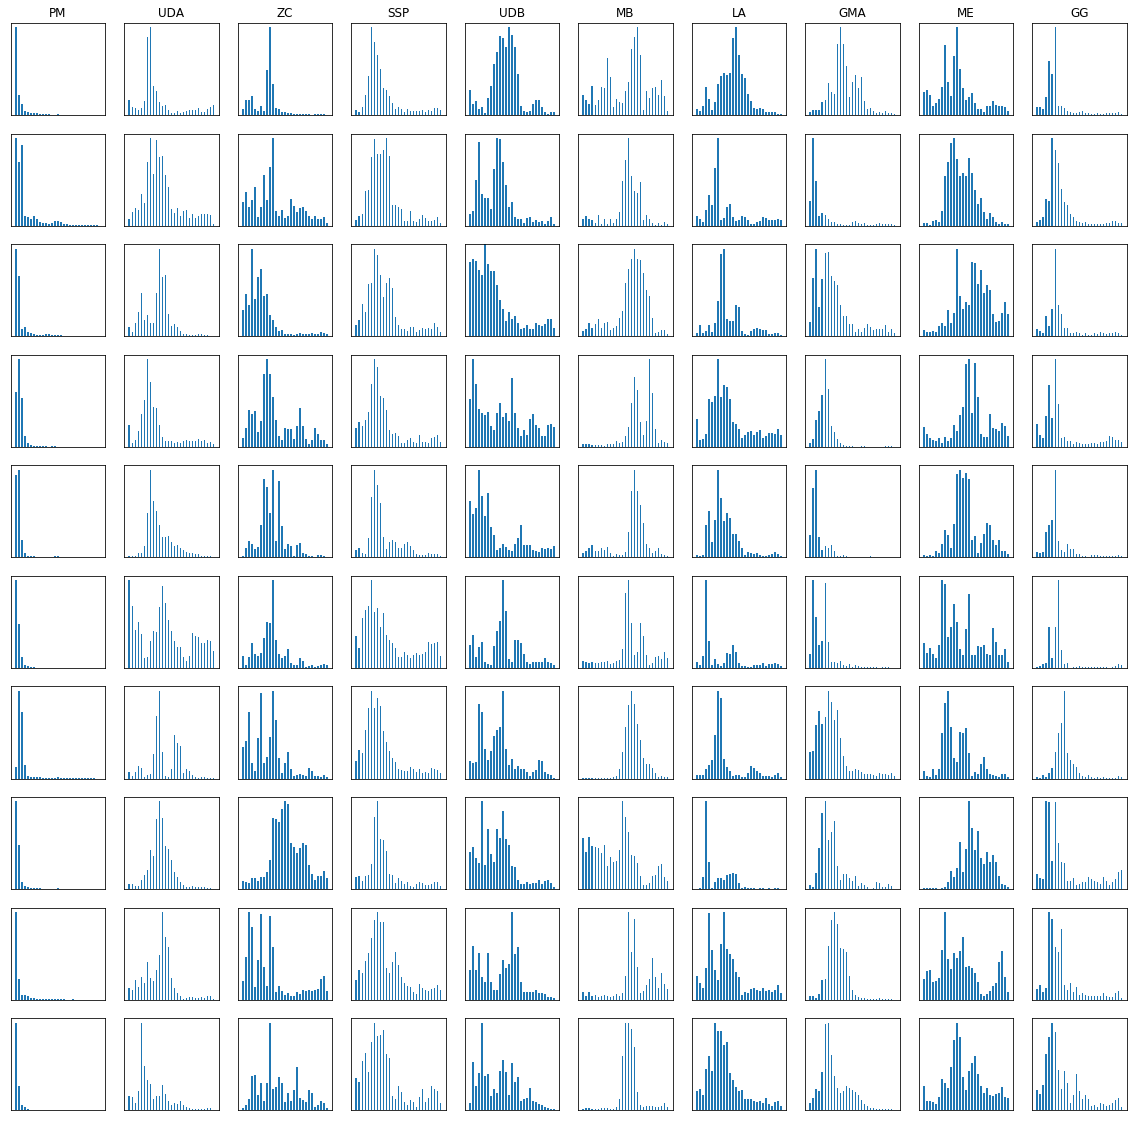

<IPython.core.display.Javascript object>

In [38]:
show_power_spectrum_per_class(10, all_classes)

### Feature: spectral width

In [59]:
def spectral_width(ps, ratio=0.5):
    pmax = ps.max()
    thresh = ratio * pmax
    width = (ps > thresh).sum()
    return widthC=50

<IPython.core.display.Javascript object>

2

<IPython.core.display.Javascript object>

## Training a linear model

In [14]:
Y = Y_train_df.TARGET.tolist()

<IPython.core.display.Javascript object>

In [15]:
def build_ps_features():
    n_samples = X_train.shape[0]
    n_feats = 29
    X = np.zeros((n_samples, n_feats), dtype=np.float32)
    for i in tqdm_notebook(range(n_samples)):
        x = segment_clicks(X_train[i], cls=Y[i], width=2 ** 8)
        _, ps = get_power_spectrum(x, n_fft=64)
        X[i] = ps
    return X

<IPython.core.display.Javascript object>

In [16]:
X = build_ps_features()

<IPython.core.display.Javascript object>

In [66]:
# !pip install --upgrade sklearn # requires scikit learn 0.22
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)

<IPython.core.display.Javascript object>

In [63]:
# Stratified split
X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X, Y, stratify=Y, test_size=0.15
)
print(f"Train size: {len(X_spec_train)}, val size: {len(X_spec_val)}")

Train size: 96152, val size: 16968


<IPython.core.display.Javascript object>

In [64]:
def normalize(X_un_train, X_un_val, norm="unit"):
    if norm == "standard":
        scaler_cls = StandardScaler()
    elif norm == "unit":
        scaler_cls = Normalizer()

    scaler = scaler_cls.fit(X_spec_train)

    X_sc_train = scaler.transform(X_spec_train)
    X_sc_val = scaler.transform(X_spec_val)
    return X_sc_train, C=50X_sc_val

<IPython.core.display.Javascript object>

In [67]:
# Scaling the data
X_sc_spec_train, X_sc_spec_val = normalize(X_spec_train, X_spec_val, norm="unit")

<IPython.core.display.Javascript object>

In [68]:
# Logistic regression
model = LogisticRegression(
    C=50,
    verbose=1,
    solver="lbfgs",
    max_iter=5000,
    multi_class="multinomial",
    random_state=0,
    tol=0.0001,
)
model.fit(X_sc_spec_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [69]:
# Val set
train_acc = model.score(X_sc_spec_train, Y_train)
val_acc = model.score(X_sc_spec_val, Y_val)

print(f"Train acc: {train_acc:.4f}")
print(f"Val acc: {val_acc:.4f}")

Train acc: 0.6401
Val acc: 0.6421


<IPython.core.display.Javascript object>

In [70]:
print("Validation")
print(classification_report(Y_val, model.predict(X_sc_spec_val)))

Validation
              precision    recall  f1-score   support

          GG       0.52      0.57      0.54      1697
         GMA       0.65      0.62      0.63      1697
          LA       0.58      0.45      0.51      1697
          MB       0.92      0.97      0.94      1696
          ME       0.65      0.71      0.67      1697
          PM       0.95      0.96      0.96      1697
         SSP       0.60      0.78      0.68      1697
         UDA       0.43      0.29      0.35      1696
         UDB       0.51      0.44      0.47      1697
          ZC       0.54      0.64      0.58      1697

    accuracy                           0.64     16968
   macro avg       0.63      0.64      0.63     16968
weighted avg       0.63      0.64      0.63     16968



<IPython.core.display.Javascript object>

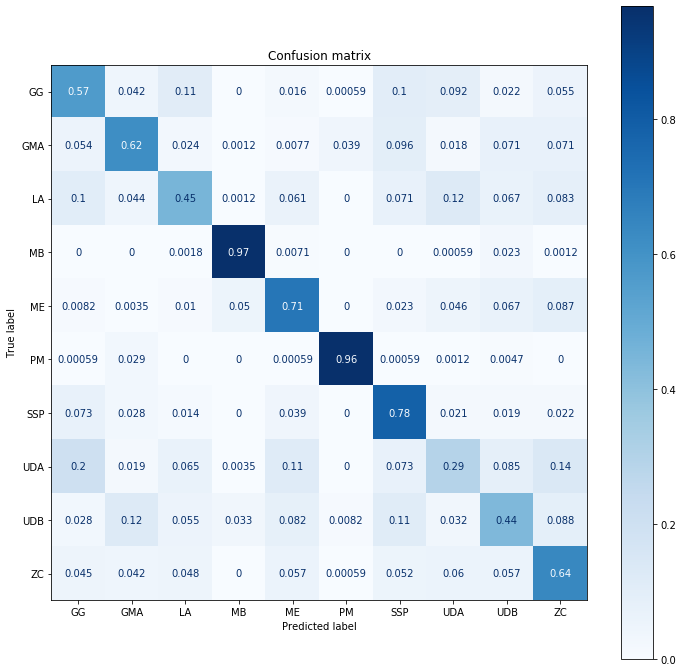

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Confusion matrix")
plot_confusion_matrix(
    model, X_sc_spec_val, Y_val, cmap=plt.cm.Blues, normalize="true", ax=ax
)

Best: 0.516 with C=50, using StandardScale